In [1]:
import os
from os import listdir
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator


In [2]:
filePathClasses = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/classes.txt' # class number to class names
filePathImagesLocations = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/images.txt' # image names
filePathImageLabels = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/image_class_labels.txt' # image number to class number
filePathSplit = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/train_test_split.txt' # image to train or test split
filePathImageFile = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/images' # image file location
filePathBoxFile = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/bounding_boxes.txt' # bounding boxes file

npyPath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/npy_folder' # location of npy files

fromFilePath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/all_images' # all images location
processedImagesPath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/processedCropped/' # processed images location

from google.colab import drive

# # Mount drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# take file and returns each line as an element in an array
def ExtractFromFile(fileLocation):
  array = []
  File = open(fileLocation, 'r')
  Lines = File.readlines()
  for line in Lines:
    lineStripped = line.strip().split(" ", 1)
    array.append(lineStripped[1])
  return array

In [ ]:
#extract class names
classes = ExtractFromFile(filePathClasses)
print(classes)
print(len(classes))

#Extract image locations
imageNames = ExtractFromFile(filePathImagesLocations)
print(imageNames)
print(len(imageNames))

#Extract image classes
imageClasses = ExtractFromFile(filePathImageLabels)
print(imageClasses)
print(len(imageClasses))

#get split of training and test set
splits = ExtractFromFile(filePathSplit)
print(splits)
print(len(splits))

#get bounding boxes
boxLabels = ExtractFromFile(filePathBoxFile)
print(boxLabels[0])
print(len(boxLabels))

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '042.Ver

In [ ]:
# remove first 4 characters from imageNames e.g. remove 001.Black_footed_Albatross/
print("bef: " + imageNames[0])
for i in range(len(imageNames)):
  new = imageNames[i].split('/')
  imageNames[i] = new[1]
print("aft: " + imageNames[0])

# split each of the values for each bounding box e.g. ['60.0', '27.0', '325.0', '304.0']
print(boxLabels[0])
for i in range(len(boxLabels)):
  boxLabels[i] = boxLabels[i].split(" ")
print(boxLabels[0])

bef: 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
aft: Black_Footed_Albatross_0046_18.jpg
60.0 27.0 325.0 304.0
['60.0', '27.0', '325.0', '304.0']


In [ ]:
# saving the array as .npy file
np.save(npyPath + '/imageNames.npy', imageNames)
np.save(npyPath + '/boxLabels.npy', boxLabels)
np.save(npyPath + '/splits.npy', splits)
np.save(npyPath + '/imageClasses.npy', imageClasses)

In [ ]:
# loading the .npy files
imageNames = np.load(npyPath + '/imageNames.npy')
boxLabels = np.load(npyPath + '/boxLabels.npy')
splits = np.load(npyPath + '/splits.npy')
imageClasses = np.load(npyPath + '/imageClasses.npy')

In [ ]:
# crop image using bounding box to remove background noise
def CropImage(box, image):
    x = int(float(box[0]))
    x2 = int(float(box[0]))+int(float(box[2]))
    y = int(float(box[1]))
    y2 = int(float(box[1]))+int(float(box[3]))
    image = image[y:y2, x:x2]
    return image

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(224, 224), # resize to 224x224
  tf.keras.layers.Rescaling(1./255) # normalization
])

counter = 0

# loop through all images and bounding boxes
for i in range(len(imageNames)):
  image = imread(fromFilePath + "/" + imageNames[i])

  image = CropImage(boxLabels[i], image) # crop the image

  image = np.array(image) # images must be converted numpy arrays before being passed through model
  
  #some images are grayscale, need to convert to rgb for cnn input
  if (len(image.shape) == 2):  
    image = np.stack((image,)*3, axis=-1)

  image = resize_and_rescale(image, np.float32) # resize and normalise

  np.save(processedImagesPath + imageNames[i] + ".npy", image)
  counter += 1
  print(counter)

Streaming output truncated to the last 5000 lines.
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978

In [ ]:
# Split between training and testing sets
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(len(imageNames)):
  print(i)
  if splits[i] == '1':
    x_train.append(imageNames[i])
    y_train.append(int(imageClasses[i])-1)
  else:
    x_test.append(imageNames[i])
    y_test.append(int(imageClasses[i])-1)

print("train: ", len(x_train))
print(x_train[0])
print("test: ", len(x_test))
print(x_test[0])

Streaming output truncated to the last 5000 lines.
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981

In [ ]:
y_train = to_categorical(y_train, 200)
y_test = to_categorical(y_test, 200)
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# saving the filename array as .npy file
np.save(npyPath + '/x_train.npy', x_train)
np.save(npyPath + '/y_train.npy', y_train)

np.save(npyPath + '/x_test.npy', x_test)
np.save(npyPath + '/y_test.npy', y_test)

In [3]:
# load the training and testing data
x_train = np.load(npyPath + '/x_train.npy')
y_train = np.load(npyPath + '/y_train.npy')

x_test = np.load(npyPath + '/x_test.npy')
y_test = np.load(npyPath + '/y_test.npy')

print(x_train[0])
print(y_train[0])

Black_Footed_Albatross_0009_34.jpg
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
#image augmentation
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.RandomFlip("horizontal"),
     tf.keras.layers.RandomTranslation(height_factor = [-0.1, 0.1], 
                                    width_factor = [-0.1, 0.1], 
                                    fill_mode = 'nearest'),
     tf.keras.layers.RandomRotation(0.1, fill_mode = 'nearest'),
     tf.keras.layers.RandomZoom(
      height_factor = [-0.1, 0.1],
      width_factor= [-0.1, 0.1],
      fill_mode='nearest',
      interpolation='bilinear',
      seed=None,
      fill_value=0.0),
      tf.keras.layers.RandomContrast(0.1)])

(1, 224, 224, 3)


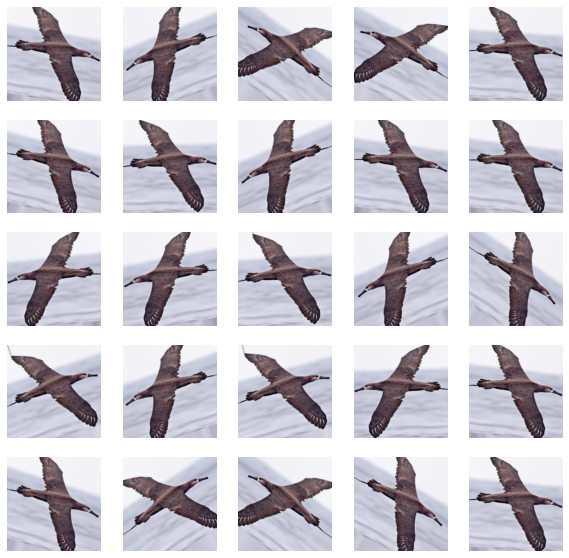

In [ ]:
# Preview single image with augmentations

image = np.load(processedImagesPath + x_train[0] + ".npy")
plt.figure(figsize=(10, 10))
for i in range(25):
  augmented_image = data_augmentation(tf.expand_dims(image, 0), tf.float32)
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

print(augmented_image.shape)


In [5]:
from skimage.transform import resize
class My_Custom_Generator(keras.utils.Sequence):
  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
  # Calculates the number of batches
  def __len__(self):
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  # Gets the filenames and labels for the batch and return an array of x and y pairs for the batch
  def __getitem__(self, index):
    batch_x = self.image_filenames[index*self.batch_size : (index+1)*self.batch_size]
    batch_y = self.labels[index*self.batch_size : (index+1)*self.batch_size]

    return np.array([np.load(processedImagesPath + str(file_name) + ".npy") for file_name in batch_x]), np.array(batch_y)

In [6]:
batch_size = 32
training_batch_generator = My_Custom_Generator(x_train, y_train, batch_size)
validation_batch_generator = My_Custom_Generator(x_test, y_test, batch_size)

In [7]:
# extract the k-heighest activiation
class KMaxPooling(tf.keras.layers.Layer):
    def __init__(self, k=3, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = tf.keras.layers.InputSpec(ndim=4)
        self.k = k

    def compute_output_shape(self, input_shape):
        return (input_shape[0], (input_shape[2] * self.k))

    def call(self, inputs):
        # reshape to a linear vector to extract the top k from the whole 7x7 
        # feature map and from all 576 feature maps
        inputs = tf.keras.layers.Reshape((49, 1, 576))(inputs)

        # input is transposed to swap dimension, as the top_k is applied on the last dimension
        inputs = tf.transpose(inputs, [0, 2, 3 , 1])

        # top_only extract the k largest values from the last dimension
        top_k = tf.math.top_k(inputs, k=self.k, sorted=True, name=None)[0]

        # transpose back
        top_k = tf.transpose(top_k , [0, 3, 1, 2])

        return top_k

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_spec': self.input_spec,
            'l': self.k,
        })
        return config

In [8]:
height = 224
width = 224
img_shape=(height, width, 3)

base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=img_shape,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling='max',
    include_preprocessing=False
)

# remove last convolutional layer
base_model = tf.keras.Model(base_model.input, base_model.layers[-2].output)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = KMaxPooling()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.8)(x)
outputs = tf.keras.layers.Dense(units = 200, activation = 'softmax')(x)

# Freeze convolutional layers
base_model.trainable = False

model = tf.keras.Model(inputs, outputs)

for layer in model.layers:
  print(layer, layer.trainable)

for layer in base_model.layers:
  print(layer, layer.trainable)

model.summary()


<keras.engine.input_layer.InputLayer object at 0x7f71ca0904d0> True
<keras.engine.sequential.Sequential object at 0x7f7264afec50> True
<keras.engine.functional.Functional object at 0x7f71ca0a88d0> False
<__main__.KMaxPooling object at 0x7f71ca070710> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f71ca0f0290> True
<keras.layers.core.dropout.Dropout object at 0x7f71ca0b9110> True
<keras.layers.core.dense.Dense object at 0x7f71c9ea7350> True
<keras.engine.input_layer.InputLayer object at 0x7f7265d955d0> False
<keras.layers.convolutional.Conv2D object at 0x7f7264b4e310> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f72642cdf10> False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7f71ca371610> False
<keras.layers.advanced_activations.ReLU object at 0x7f71ca3b6450> False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7f71ca371690> False
<keras.layers.merge.Multiply object at 0x7f71ca3715d0> False
<keras.layers.convolutio

In [9]:
model.compile(optimizer = 'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=25, 
                                            restore_best_weights=True)
history = model.fit(training_batch_generator,
                    batch_size = 32,
                    epochs = 600,
                    verbose = 1,
                    validation_data = validation_batch_generator,
                    callbacks=[callback])

Epoch 1/600
188/188 [==============================] - 42s 191ms/step - loss: 48.6031 - accuracy: 0.0045 - val_loss: 18.4604 - val_accuracy: 0.0109
Epoch 2/600
188/188 [==============================] - 34s 182ms/step - loss: 41.7066 - accuracy: 0.0042 - val_loss: 15.4736 - val_accuracy: 0.0283
Epoch 3/600
188/188 [==============================] - 34s 180ms/step - loss: 37.4555 - accuracy: 0.0065 - val_loss: 13.1651 - val_accuracy: 0.0561
Epoch 4/600
188/188 [==============================] - 34s 179ms/step - loss: 33.7424 - accuracy: 0.0080 - val_loss: 12.3189 - val_accuracy: 0.0901
Epoch 5/600
188/188 [==============================] - 34s 180ms/step - loss: 30.6562 - accuracy: 0.0177 - val_loss: 11.4355 - val_accuracy: 0.0894
Epoch 6/600
188/188 [==============================] - 34s 180ms/step - loss: 27.9385 - accuracy: 0.0204 - val_loss: 10.4991 - val_accuracy: 0.1275
Epoch 7/600
188/188 [==============================] - 34s 180ms/step - loss: 25.8971 - accuracy: 0.0257 - val_l

In [10]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

for layer in model.layers[1].layers:
  print(layer, layer.trainable)

<keras.layers.preprocessing.image_preprocessing.RandomFlip object at 0x7f7264b6ed90> True
<keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7f726e56f850> True
<keras.layers.preprocessing.image_preprocessing.RandomRotation object at 0x7f72d940b090> True
<keras.layers.preprocessing.image_preprocessing.RandomZoom object at 0x7f7264afe610> True
<keras.layers.preprocessing.image_preprocessing.RandomContrast object at 0x7f7264afe650> True


In [ ]:
#load weights
model.load_weights("/content/drive/MyDrive/ArronCNN/modelweights/best3.hdf5")

In [ ]:
filepath = "/content/drive/MyDrive/ArronCNN/modelweights/best3.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            patience=20, 
                                            restore_best_weights=True)
history = model.fit(training_batch_generator,
                    batch_size = 32,
                    epochs = 1500,
                    verbose = 1,
                    validation_data = validation_batch_generator,
                    callbacks=[checkpoint, callback])

Epoch 1/1500
188/188 [==============================] - ETA: 0s - loss: 32.3851 - accuracy: 0.0240
Epoch 1: val_accuracy improved from -inf to 0.31774, saving model to /content/drive/MyDrive/ArronCNN/modelweights/best3.hdf5
188/188 [==============================] - 44s 199ms/step - loss: 32.3851 - accuracy: 0.0240 - val_loss: 5.3603 - val_accuracy: 0.3177
Epoch 2/1500
188/188 [==============================] - ETA: 0s - loss: 25.6920 - accuracy: 0.0259
Epoch 2: val_accuracy improved from 0.31774 to 0.33673, saving model to /content/drive/MyDrive/ArronCNN/modelweights/best3.hdf5
188/188 [==============================] - 36s 192ms/step - loss: 25.6920 - accuracy: 0.0259 - val_loss: 3.9953 - val_accuracy: 0.3367
Epoch 3/1500
188/188 [==============================] - ETA: 0s - loss: 20.1093 - accuracy: 0.0252
Epoch 3: val_accuracy did not improve from 0.33673
188/188 [==============================] - 35s 188ms/step - loss: 20.1093 - accuracy: 0.0252 - val_loss: 3.3774 - val_accuracy: 0

In [ ]:
#save the model
model.save("/content/drive/MyDrive/ArronCNN/myModel")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ArronCNN/myModel/assets


In [ ]:
#Load the model
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/ArronCNN/myModel")

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_batch_generator, verbose=2)

print(test_acc)

In [ ]:
# SaveModel into tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/My Drive/ArronCNN/ModelsForApp/BirdModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()